In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import boxcox
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, roc_curve, auc
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set seaborn color palette

flatui = ["#4F8488", "#DCBB58", "#77AD9E"]
sns.set_palette(flatui)
sns.set_style('ticks')
sns.set_context("poster")

In [2]:
A_train = pd.read_csv('./data/TrainingDataA.csv', header=None)
B_train = pd.read_csv('./data/TrainingDataB.csv', header=None)
time = pd.read_csv('./data/SampleTimesInSec.csv', header=None)
test = pd.read_csv('./data/BlindData.csv', header=None)
        
A_df = A_train.T
A_df['Class'] = 'Type A'
A_df['time'] = time.T

B_df = B_train.T
B_df['Class'] = 'Type B'
B_df['time'] = time.T

train = pd.concat([A_df, B_df])

train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Class,time
0,0.411405,0.396065,0.388995,0.412835,0.407972,0.403826,0.415033,0.412278,0.414171,0.423174,...,0.423869,0.414593,0.426611,0.419937,0.408008,0.420793,0.406820,0.415330,Type A,0.005
1,0.419165,0.400590,0.391025,0.398082,0.410007,0.407877,0.401225,0.410014,0.413718,0.430396,...,0.417587,0.419367,0.428523,0.424560,0.407076,0.423664,0.394772,0.413024,Type A,0.006
2,0.411505,0.389948,0.386694,0.412636,0.401110,0.399939,0.401809,0.398089,0.417291,0.420428,...,0.425673,0.407333,0.422531,0.427149,0.413272,0.407916,0.393649,0.416995,Type A,0.008
3,0.397064,0.392908,0.388490,0.399866,0.403072,0.399598,0.393319,0.412890,0.412810,0.416560,...,0.421975,0.415079,0.423136,0.423718,0.397417,0.411662,0.404152,0.414956,Type A,0.009
4,0.415763,0.386306,0.392952,0.399564,0.404002,0.393668,0.397410,0.403078,0.408819,0.415913,...,0.413643,0.412461,0.423793,0.410518,0.390596,0.407772,0.394500,0.405972,Type A,0.011


In [4]:
# Transforming dataset for relplot
    
df = time.T

df = df.merge(A_train.T[0], how='outer', left_index=True, right_index=True)
df.columns = ['time', 'signal']
df['Class'] = 'Type A'

for k in range(1, 300):
    
    temp = time.T
    temp = temp.merge(A_train.T[k], how='outer', left_index=True, right_index=True)
    temp.columns = ['time', 'signal']
    temp['Class'] = 'Type A'
    df = df.append(temp, ignore_index=True) 
    
for i in range(300):
    temp = time.T
    temp = temp.merge(B_train.T[i], how='outer', left_index=True, right_index=True)
    temp.columns = ['time', 'signal']
    temp['Class'] = 'Type B'
    df = df.append(temp, ignore_index=True) 

df

,time,signal,Class
0,0.005,0.411405,Type A
1,0.006,0.419165,Type A
2,0.008,0.411505,Type A
3,0.009,0.397064,Type A
4,0.011,0.415763,Type A
...,...,...,...
17995,0.875,0.100918,Type B
17996,1.076,0.087232,Type B
17997,1.323,0.066165,Type B
17998,1.627,0.070270,Type B


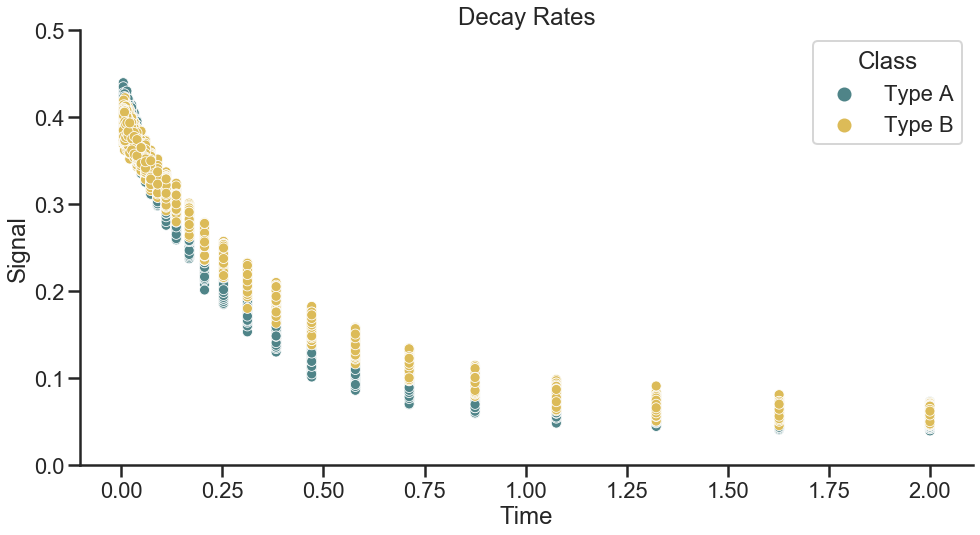

In [5]:
f = plt.figure(figsize=(16, 8))

sns.scatterplot(data=df, x='time', y='signal', hue='Class', s=100)

plt.ylabel('Signal')
plt.xlabel('Time')
plt.title('Decay Rates')
sns.despine()

plt.xticks(np.arange(0.0, 2.25, step=0.25))

plt.yticks(np.arange(0.0, 0.6, step=0.1))

plt.show()
f.savefig('./plots/decay_collective.png', transparent=True)

In [6]:
# Curve fit function
def func(x, a1, a2, b0, b1, b2):
        return b0 + b1*np.exp(-a1*x) + b2*np.exp(-a2*x)

# Get parameters for curve fit example
params_A, _ = curve_fit(func, time.to_numpy()[0], train[train['Class']=='Type A'][0].to_numpy(), 
                     maxfev=1000, bounds=((0, 0, -np.inf, -np.inf, -np.inf), 
                             (10, 10, np.inf, np.inf, np.inf)))

params_B, _ = curve_fit(func, time.to_numpy()[0], train[train['Class']=='Type B'][0].to_numpy(), 
                     maxfev=1000, bounds=((0, 0, -np.inf, -np.inf, -np.inf), 
                             (10, 10, np.inf, np.inf, np.inf)))

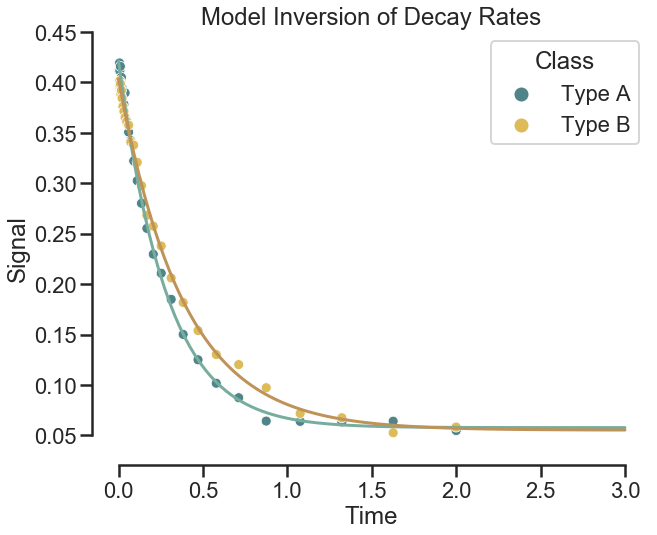

In [7]:
# Curve fit example
f = plt.figure(figsize=(10, 8))
x_min = 0
x_max = 3
x_fit = np.linspace(x_min, x_max, 100)

sns.scatterplot(data=train, x='time', y=train[0], s=100, hue='Class')
plt.plot(x_fit, func(x_fit, *params_A), '-', c='#77AD9E')
plt.plot(x_fit, func(x_fit, *params_B), '-', c='#BF9258')
sns.despine(trim=True)

plt.ylabel('Signal')
plt.xlabel('Time')
plt.title('Model Inversion of Decay Rates')
plt.savefig('./plots/decay_fit.png', transparent=True)
    
plt.show()

In [8]:
# Model inversion function
def get_coefs(time, df, label):
    
    def func(x, a1, a2, b0, b1, b2):
        return b0 + b1*np.exp(-a1*x) + b2*np.exp(-a2*x)
    
    t = time.to_numpy()[0]
    
    res = [curve_fit(func, t, df[df['Class']==label][i].to_numpy(), maxfev=10000, 
                     bounds=((1, 1, -np.inf, -np.inf, -np.inf), 
                             (10, 10, np.inf, np.inf, -1))) for i in range(300)]
    
    return res

In [9]:
# Get decay rate estimations for Type A
coefs_A = get_coefs(time, train, 'Type A')

a1_A = np.array([trial[0][0] for trial in coefs_A])
a2_A = np.array([trial[0][1] for trial in coefs_A])

# Get decay rate estimations for Type B
coefs_B = get_coefs(time, train, 'Type B')

a1_B = np.array([trial[0][0] for trial in coefs_B])
a2_B = np.array([trial[0][1] for trial in coefs_B])

In [14]:
# Make decay rate dataframe

df = pd.DataFrame({'a1': a1_A, 'a2': a2_A})
df['type'] = 1

df2 = pd.DataFrame({'a1': a1_B, 'a2': a2_B})
df2['type'] = 0

df = pd.concat([df, df2]).reset_index(drop=True)

df

,a1,a2,type
0,4.165282,4.319087,1
1,3.250925,3.250920,1
2,4.700889,5.090244,1
3,3.289471,3.289461,1
4,3.398301,3.398303,1
...,...,...,...
595,2.508045,2.508037,0
596,2.387145,2.387136,0
597,2.588306,2.588314,0
598,2.681436,2.769253,0


In [15]:
# Log transform decay rates

df['a1'] = boxcox(df['a1'], 0)
df['a2'] = boxcox(df['a2'], 0)

df

,a1,a2,type
0,1.426784,1.463044,1
1,1.178940,1.178938,1
2,1.547752,1.627326,1
3,1.190727,1.190724,1
4,1.223276,1.223276,1
...,...,...,...
595,0.919503,0.919500,0
596,0.870098,0.870094,0
597,0.951003,0.951007,0
598,0.986352,1.018578,0


mean:              a1
type          
0     0.971245
1     1.310558
variance:              a1
type          
0     0.011497
1     0.010049


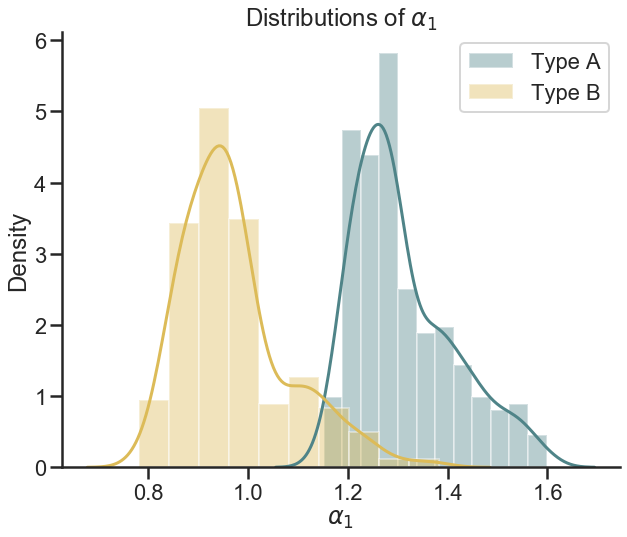

mean:              a2
type          
0     0.983561
1     1.326591
variance:              a2
type          
0     0.016337
1     0.014741


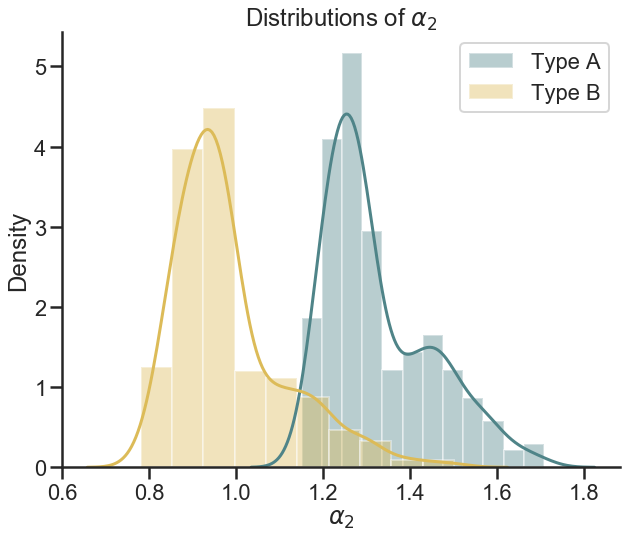

In [17]:
f = plt.figure(figsize=(10, 8))

sns.distplot(df[df['type'] == 1]['a1'], label='Type A', bins=12)
sns.distplot(df[df['type'] == 0]['a1'], label='Type B', bins=10)
sns.despine()

# Plot formatting
plt.legend()
plt.title('Distributions of $\\alpha_1$')
plt.xlabel('$\\alpha_1$')
plt.ylabel('Density')
print('mean: ', df[['a1', 'type']].groupby(['type']).mean())
print('variance: ', df[['a1', 'type']].groupby(['type']).var())
plt.savefig('./plots/a1_density_tf.png', transparent=True)
plt.show()

f = plt.figure(figsize=(10, 8))

sns.distplot(df[df['type'] == 1]['a2'], label='Type A', bins=12)
sns.distplot(df[df['type'] == 0]['a2'], label='Type B', bins=10)
sns.despine()

# Plot formatting
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.title('Distributions of $\\alpha_2$')
plt.xlabel('$\\alpha_2$')
print('mean: ', df[['a2', 'type']].groupby(['type']).mean())
print('variance: ', df[['a2', 'type']].groupby(['type']).var())
plt.ylabel('Density')
plt.savefig('./plots/a2_density_tf.png', transparent=True)
plt.show()

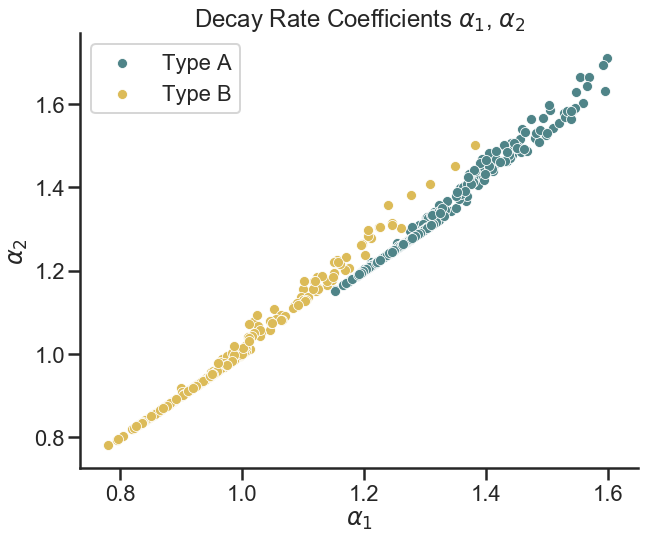

In [18]:
f = plt.figure(figsize=(10, 8))

sns.scatterplot(x=df[df['type'] == 1]['a1'], y=df[df['type'] == 1]['a2'], 
                s=100, label='Type A', color='#4F8488')
sns.scatterplot(x=df[df['type'] == 0]['a1'], y=df[df['type'] == 0]['a2'], 
                s=100, label='Type B', 
                color='#DCBB58')
sns.despine()

plt.ylabel('$\\alpha_2$')
plt.xlabel('$\\alpha_1$')
plt.title('Decay Rate Coefficients $\\alpha_1$, $\\alpha_2$')
plt.savefig('./plots/decay_ratio_tf.png')
    
plt.show()

In [19]:
def run_cv(X, y, model):
    plt.clf()
    
    X = X.to_numpy()
    y = y.to_numpy()
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    y_agg_test = []
    y_agg_preds = []
    y_agg_proba = []
    
    def join_np(a1, a2):
        for i in a2:
            a1.append(i)
        return a1
            
    for train, test in cv.split(X, y):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_preds = model.predict(X_test)
        y_agg_test = join_np(y_agg_test, y_test)
        y_agg_preds = join_np(y_agg_preds, y_preds)    
        y_agg_proba = join_np(y_agg_proba, y_proba)

    fpr, tpr, _ = roc_curve(y_true=y_agg_test, y_score=y_agg_proba)
    auc = roc_auc_score(y_agg_test, y_agg_proba)
    print(accuracy_score(y_agg_test, y_agg_preds))
    
    res = pd.DataFrame({'label': y_agg_preds, 'stat': y_agg_proba})
    
    print('mean: ', res.groupby(['label']).mean())
    print('variance: ', res.groupby(['label']).var())

    print(res['label'].value_counts())
    print(confusion_matrix(y_agg_test, y_agg_preds))
    
    return model, fpr, tpr, auc, y_agg_proba, y_agg_preds, y_agg_test

In [27]:
def plot_roc(X, y, models):
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

    # Train the models and record the results
    for cls in models:
        print(cls.__class__.__name__)
        res = run_cv(X, y, cls)
        result_table = result_table.append({'classifiers':res[0].__class__.__name__,
                                            'fpr':res[1], 
                                            'tpr':res[2], 
                                            'auc':res[3]}, ignore_index=True)

    # Set name of the classifiers as index labels
    result_table.set_index('classifiers', inplace=True)

    fig = plt.figure(figsize=(10,8))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']),
                 linewidth=4.0)

    plt.plot([0,1], [0,1], color='#C09258', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate")

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate")

    plt.title('ROC Curve Analysis – Not Tuned')
    plt.legend(prop={'size':20}, loc='lower right')
    sns.despine()
    plt.savefig('./plots/roc_not_tuned_tf.png', transparent=True)
    plt.show()
    
    return

LogisticRegression
0.945
mean:             stat
label          
0      0.115758
1      0.812615
variance:             stat
label          
0      0.011313
1      0.016707
1    331
0    269
Name: label, dtype: int64
[[268  32]
 [  1 299]]
LinearDiscriminantAnalysis
0.9983333333333333
mean:             stat
label          
0      0.001004
1      0.999538
variance:             stat
label          
0      0.000084
1      0.000028
1    301
0    299
Name: label, dtype: int64
[[299   1]
 [  0 300]]
KNeighborsClassifier
0.9866666666666667
mean:             stat
label          
0      0.004795
1      0.992208
variance:             stat
label          
0      0.001489
1      0.002545
1    308
0    292
Name: label, dtype: int64
[[292   8]
 [  0 300]]


<Figure size 432x288 with 0 Axes>

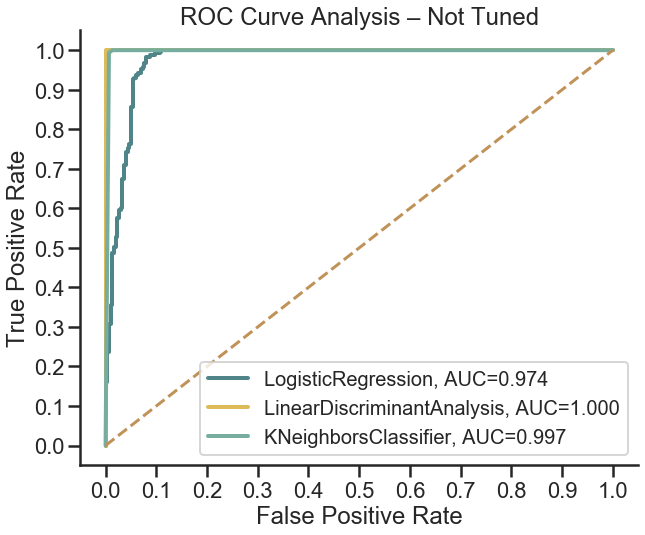

In [52]:
X = df.drop(['type'], axis=1)
y = df.type

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(), 
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier(n_neighbors=5)]

plot_roc(X, y, classifiers)

In [53]:
# Tune LR model

cv = StratifiedKFold(n_splits=5, random_state=1)

grid = {"C":np.logspace(-3,3,7), 
        "penalty":["l1","l2"]
       }

lr = LogisticRegression()
search = GridSearchCV(lr, grid, scoring='accuracy', cv=cv, n_jobs=-1)

results = search.fit(X, y)
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.998
Config: {'C': 1000.0, 'penalty': 'l2'}


0.9983333333333333
mean:             stat
label          
0      0.001143
1      0.999571
variance:             stat
label          
0      0.000134
1      0.000024
1    301
0    299
Name: label, dtype: int64
[[299   1]
 [  0 300]]


<Figure size 432x288 with 0 Axes>

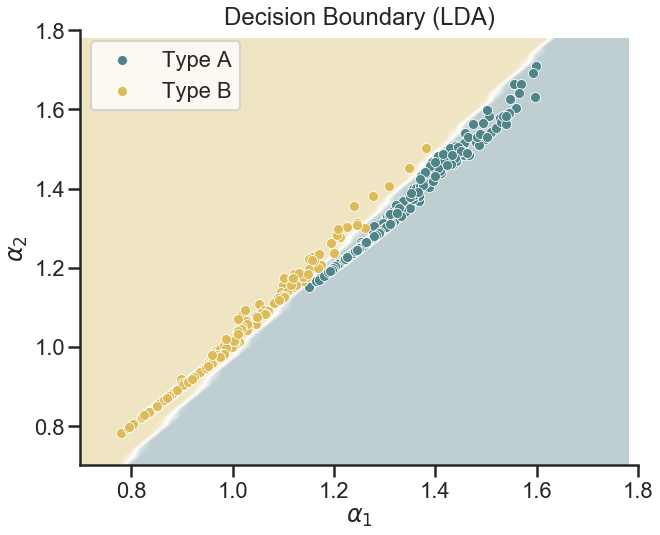

In [54]:
clf = run_cv(X, y, LinearDiscriminantAnalysis(shrinkage=0, solver='lsqr'))[0]

f, ax = plt.subplots(figsize=(10, 8))

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#EFE4C0"],
          [norm(0), '#FFFFFF'],
          [norm(1.0), "#BCCDCF"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

x_min, x_max = 0.7, 1.8
y_min, y_max = 0.7, 1.8
h = .02  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

contour = ax.contourf(xx, yy, probs, 25, cmap=cmap,
                      vmin=0, vmax=1)

sns.scatterplot(x=df[df['type'] == 1]['a1'], y=df[df['type'] == 1]['a2'], 
                s=100, label='Type A', color='#4F8488')
sns.scatterplot(x=df[df['type'] == 0]['a1'], y=df[df['type'] == 0]['a2'], 
                s=100, label='Type B', 
                color='#DCBB58')

ax.set(xlim=(0.7, 1.8), ylim=(0.7, 1.8),
       xlabel="$\\alpha_1$", ylabel="$\\alpha_2$")

plt.title('Decision Boundary (LDA)')
sns.despine()
plt.savefig('./plots/decision_boundary_lda_tf.png', transparent=True)

plt.show()

0.9983333333333333
mean:             stat
label          
0      0.018049
1      0.979589
variance:             stat
label          
0      0.003608
1      0.001368
1    301
0    299
Name: label, dtype: int64
[[299   1]
 [  0 300]]


<Figure size 432x288 with 0 Axes>

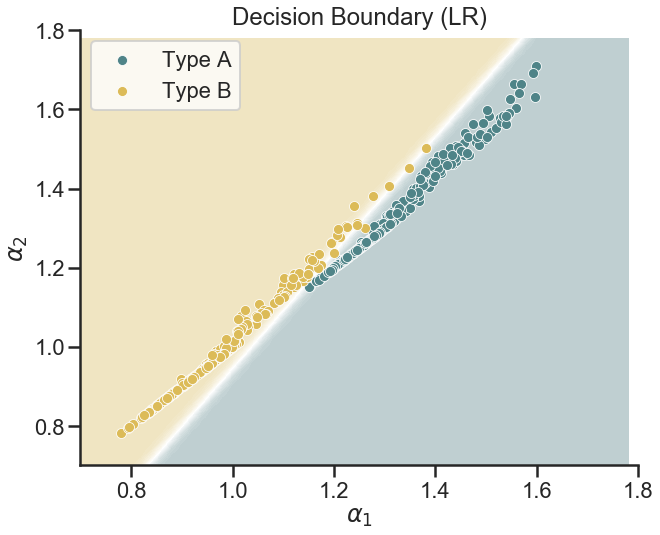

In [56]:
res = run_cv(X, y, LogisticRegression(C=1000, penalty='l2'))
clf = res[0]

f, ax = plt.subplots(figsize=(10, 8))

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#EFE4C0"],
          [norm(0), '#FFFFFF'],
          [norm(1.0), "#BCCDCF"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

x_min, x_max = 0.7, 1.8
y_min, y_max = 0.7, 1.8
h = .02  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

contour = ax.contourf(xx, yy, probs, 25, cmap=cmap,
                      vmin=0, vmax=1)

sns.scatterplot(x=df[df['type'] == 1]['a1'], y=df[df['type'] == 1]['a2'], 
                s=100, label='Type A', color='#4F8488')
sns.scatterplot(x=df[df['type'] == 0]['a1'], y=df[df['type'] == 0]['a2'], 
                s=100, label='Type B', 
                color='#DCBB58')

ax.set(xlim=(0.7, 1.8), ylim=(0.7, 1.8),
       xlabel="$\\alpha_1$", ylabel="$\\alpha_2$")

plt.title('Decision Boundary (LR)')
sns.despine()
plt.savefig('./plots/decision_boundary_lr_tf.png', transparent=True)

plt.show()

0.9916666666666667
mean:             stat
label          
0      0.002321
1      0.995872
variance:             stat
label          
0      0.000572
1      0.001225
1    305
0    295
Name: label, dtype: int64
[[295   5]
 [  0 300]]


<Figure size 432x288 with 0 Axes>

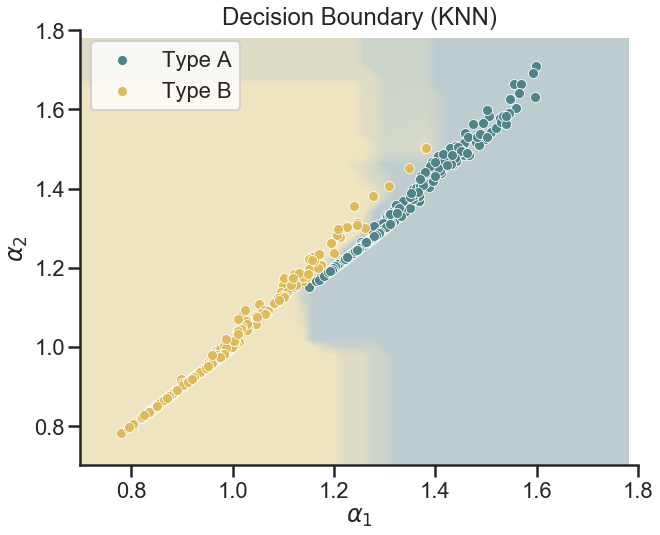

In [58]:
clf = run_cv(X, y, KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance'))[0]

f, ax = plt.subplots(figsize=(10, 8))

norm = matplotlib.colors.Normalize(-1,1)
colors = [[norm(-1.0), "#EFE4C0"],
          [norm(1.0), "#BCCDCF"]]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

x_min, x_max = 0.7, 1.8
y_min, y_max = 0.7, 1.8
h = .02  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

contour = ax.contourf(xx, yy, probs, 25, cmap=cmap,
                      vmin=0, vmax=1)

sns.scatterplot(x=df[df['type'] == 1]['a1'], y=df[df['type'] == 1]['a2'], 
                s=100, label='Type A', color='#4F8488')
sns.scatterplot(x=df[df['type'] == 0]['a1'], y=df[df['type'] == 0]['a2'], 
                s=100, label='Type B', 
                color='#DCBB58')

ax.set(xlim=(0.7, 1.8), ylim=(0.7, 1.8),
       xlabel="$\\alpha_1$", ylabel="$\\alpha_2$")

plt.title('Decision Boundary (KNN)')
sns.despine()
plt.savefig('./plots/decision_boundary_knn_tf.png', transparent=True)

plt.show()

In [33]:
def get_test_coefs(time, df):
    
    def func(x, a1, a2, b0, b1, b2):
        return b0 + b1*np.exp(-a1*x) + b2*np.exp(-a2*x)
    
    t = time.to_numpy()[0]
    
    res = [curve_fit(func, t, df[i].to_numpy(), maxfev=10000, 
                     bounds=((1, 1, -np.inf, -np.inf, -np.inf), 
                             (10, 10, np.inf, np.inf, -1))) for i in range(100)]
    
    return res

def blind_test(X, y, X_test, model):
    model.fit(X, y)
    y_proba = np.round(model.predict_proba(X_test)[:, 1], 3)
    y_preds = model.predict(X_test)
    
    res = pd.DataFrame({'stat': y_proba, 'label': y_preds})
    
    print(res.groupby(['label']).mean())
    print(res['label'].value_counts())
    
    return res

In [36]:
test = pd.read_csv('./data/BlindData.csv', header=None)

test_df = test.T
test_df['time'] = time.T

test_df.head(5)

coefs_test = get_test_coefs(time, test_df)

a1_test = np.array([trial[0][0] for trial in coefs_test])
a2_test = np.array([trial[0][1] for trial in coefs_test])

X_test = pd.DataFrame({'a1': a1_test, 'a2': a2_test})

X_test['a1'] = boxcox(X_test['a1'], 0)
X_test['a2'] = boxcox(X_test['a2'], 0)

lda_res = blind_test(X, y, X_test, LinearDiscriminantAnalysis(shrinkage=0, solver='lsqr'))

lda_res.groupby(['label']).mean()

lda_res['label'] = np.where(lda_res['label'] == 1, 'A', 'B')

lda_res

           stat
label          
0      0.000261
1      0.995926
1    54
0    46
Name: label, dtype: int64


,stat,label
0,1.0,A
1,1.0,A
2,0.0,B
3,0.0,B
4,1.0,A
...,...,...
95,1.0,A
96,1.0,A
97,0.0,B
98,1.0,A


In [38]:
lda_res.to_csv("./data/BlindTestResults_jgh33.txt", header=None, index=None, sep=' ', mode='w')